<a href="https://colab.research.google.com/github/SalahFattah/explainability/blob/main/Explainable_AI_For_Colorectal_Cancer_Detection_Using_Vision_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install evaluate
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
import os
import glob
import random
import pandas as pd
from sklearn.model_selection import train_test_split

**dataset**

In [ ]:
def load_image_paths(data_root):
    image_paths = []
    labels = []

    label_names = sorted([
        name for name in os.listdir(data_root)
        if os.path.isdir(os.path.join(data_root, name)) and not name.startswith('.')
    ])

    label2id = {label: idx for idx, label in enumerate(label_names)}

    for label in label_names:
        class_dir = os.path.join(data_root, label)
        for img_path in glob.glob(os.path.join(class_dir, '*.tif')):
            image_paths.append(img_path)
            labels.append(label2id[label])

    return pd.DataFrame({"image_path": image_paths, "label": labels}), label2id


In [ ]:
data_root = '/content/drive/MyDrive/Colorectal_Histology/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000'

In [ ]:
df, label2id = load_image_paths(data_root)

In [ ]:
label2id

{'ADIPOSE': 0,
 'COMPLEX': 1,
 'DEBRIS': 2,
 'EMPTY': 3,
 'LYMPHO': 4,
 'MUCOSA': 5,
 'STROMA': 6,
 'TUMOR': 7}

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)


In [ ]:
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "validation": Dataset.from_pandas(val_df.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
})


In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['image_path', 'label'],
        num_rows: 3500
    })
    validation: Dataset({
        features: ['image_path', 'label'],
        num_rows: 750
    })
    test: Dataset({
        features: ['image_path', 'label'],
        num_rows: 750
    })
})

**Preprocessing**

In [ ]:
import requests
import torch
from PIL import Image
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments
from tqdm import tqdm

In [ ]:
model_name = "google/vit-base-patch16-224"                        # the model name
image_processor = ViTImageProcessor.from_pretrained(model_name)   # load the image processor
model = ViTForImageClassification.from_pretrained(model_name, output_attentions=True)# loading the pre-trained model

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
from torchvision import transforms
from PIL import Image

In [ ]:
def transform(examples):
  # convert all images to RGB format, then preprocessing it using our image processor
  inputs = image_processor([Image.open(img).convert("RGB") for img in examples["image_path"]], return_tensors="pt")

  return {"pixel_values": inputs["pixel_values"],"labels":examples["label"]}



In [ ]:
dataset = ds.with_transform(transform)

In [ ]:
dataset['train'][0]['pixel_values'].shape

torch.Size([3, 224, 224])

In [ ]:
import matplotlib.pyplot as plt
def show_image(dataset, split, index):
    data = dataset[split][index]
    image_tensor = data['pixel_values']
    label = data['labels']

    # Convert the tensor to a NumPy array and display the image
    image_array = image_tensor.numpy()  # Convert the torch tensor to a NumPy array
    print(image_array.shape)
    # plt.figure(figsize=(1, 1))
    plt.imshow(image_array.transpose(1, 2, 0))  # Matplotlib expects the channel dimension last
    plt.title(f"Class {label}", fontsize=8)
    plt.axis('off')  # Hide the axis
    plt.show()

(3, 224, 224)


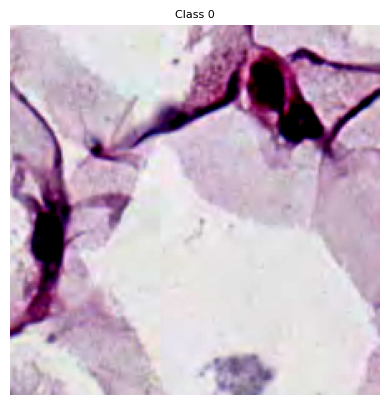

In [ ]:
import matplotlib.image
idx = 7

show_image(dataset, "train", idx)

In [ ]:
labels=list(label2id.keys())
print(labels)

In [ ]:
def collate_fn(batch):
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor([x["labels"] for x in batch]),
  }


In [ ]:
from evaluate import load
import numpy as np

# load the accuracy and f1 metrics from the evaluate module
accuracy = load("accuracy")
f1 = load("f1")

def compute_metrics(eval_pred):
  # compute the accuracy and f1 scores & return them
  accuracy_score = accuracy.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids)
  f1_score = f1.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids, average="macro")
  return {**accuracy_score, **f1_score}

In [ ]:
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True,
)

In [ ]:
import accelerate
import transformers

In [ ]:
# defining the training arguments
training_args = TrainingArguments(
  output_dir="./vit-base-colerctal", # output directory
  per_device_train_batch_size=16, # batch size per device during training
  eval_strategy="steps",    # evaluation strategy to adopt during training
  num_train_epochs=10,             # total number of training epochs
  # fp16=True,                    # use mixed precision
  save_steps=374,                # number of update steps before saving checkpoint
  eval_steps=374,                # number of update steps before evaluating
  logging_steps=374,             # number of update steps before logging
  save_total_limit=2,             # limit the total amount of checkpoints on disk
  remove_unused_columns=False,    # remove unused columns from the dataset
  push_to_hub=False,              # do not push the model to the hub
  report_to='tensorboard',        # report metrics to tensorboard
  load_best_model_at_end=True,    # load the best model at the end of training
)

In [ ]:
# Create Trainer
from transformers import Trainer

trainer = Trainer(
    model=model,                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                 # training arguments, defined above
    data_collator=collate_fn,           # the data collator that will be used for batching
    compute_metrics=compute_metrics,    # the metrics function that will be used for evaluation
    train_dataset=dataset["train"],     # training dataset
    eval_dataset=dataset["validation"], # evaluation dataset
    tokenizer=image_processor,          # the processor that will be used for preprocessing the images
)

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate(dataset["test"])

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

outputs = trainer.predict(dataset["test"])
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

# labels = dataset["train"].features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred, average=None)
precision, recall, f1_score, support

In [ ]:
data = trainer.state.log_history
# Extracting data for plotting
epochs = [entry['epoch'] for entry in data]  # Extract epoch values
train_losses = [entry['loss'] for entry in data if 'loss' in entry]  # Extract training losses
eval_losses = [entry['eval_loss'] for entry in data if 'eval_loss' in entry]  # Extract evaluation losses

# Plotting training and evaluation metrics
plt.figure(figsize=(6, 4))

plt.plot(epochs[:len(train_losses)], train_losses, label='Training Loss')
plt.plot(epochs[:len(eval_losses)], eval_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.title('Training and Evaluation Metrics Across Epochs')
plt.legend()
# plt.grid(True)
plt.show()

In [ ]:

loghistory = pd.DataFrame(trainer.state.log_history)
loghistory = loghistory.fillna(0)
loghistory = loghistory.groupby(['epoch']).sum()
fig, ax = plt.subplots(figsize=(6, 4))  # Set the size here (width, height)
loghistory[["eval_accuracy"]].plot(subplots=True, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Validation ACC'], loc='best')
plt.show()  # Display the plot

**Attention rollout**

In [ ]:
image_path_roll = "./drive/MyDrive/cd/10B02_CRC-Prim-HE-07_014.tif_Row_301_Col_2251.tif"
image_roll = Image.open(image_path_roll).convert("RGB")
inputs_roll = image_processor(images=image_roll, return_tensors="pt").to(device)

In [ ]:
import cv2
from typing import List, Callable, Optional

In [ ]:
def get_attention_rollout(model, inputs):
    discard_ratio=0.7
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs,output_attentions=True)
        attentions = outputs.attentions  # Tuple of attention tensors for each layer

    num_tokens = attentions[0].size(-1)
    result = torch.eye(num_tokens).to(device)
    ###########################
    for attn in attentions:
        attn_heads_fused = attn.mean(dim=1)  # Average over heads


        # flat = attn_heads_fused.view(attn_heads_fused.size(0), -1)
        # _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
        # indices = indices[indices != 0]
        # flat[0, indices] = 0

        attn_heads_fused += torch.eye(num_tokens).to(device)  # Add residual connection
        attn_heads_fused /= attn_heads_fused.sum(dim=-1, keepdim=True)  # Normalize
        result = torch.matmul(attn_heads_fused, result)

    mask = result[0, 0, 1:]  # Discard CLS token
    width = height = int(np.sqrt(mask.shape[0]))
    mask = mask.reshape(height, width).cpu().numpy()
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    return mask



In [ ]:
rollout_mask = get_attention_rollout(model, inputs_roll)
rollout_mask_resized = Image.fromarray(np.uint8(rollout_mask * 255)).resize(image_roll.size, resample=Image.BILINEAR)
rollout_mask_resized = np.array(rollout_mask_resized) / 255.0  # Normalize back to [0,1]

# Convert image to numpy and normalize
image_np = np.array(image_roll) / 255.0

# Apply colormap to mask
cmap = plt.get_cmap('jet')
colored_mask = cmap(rollout_mask_resized)[..., :3]  # Drop alpha channel

# Blend original image with attention mask
alpha = 0.5
blended = (1 - alpha) * image_np + alpha * colored_mask
blended = np.clip(blended, 0, 1)

# Display side-by-side
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.axis('off')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(blended)
plt.axis('off')
plt.title("ViT Attention Rollout")

plt.tight_layout()
plt.show()

**Average Drop**

In [ ]:
def compute_average_drop2(model, image: Image.Image, rollout_mask: np.ndarray, processor):
    device = model.device
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.nn.functional.softmax(logits, dim=-1)
        predicted_class = probs.argmax(dim=-1)
        original_conf = probs[0, predicted_class].item()

    # Resize mask and apply to image
    rollout_resized = cv2.resize(rollout_mask, (image.width, image.height))
    rollout_resized = (rollout_resized - rollout_resized.min()) / (rollout_resized.max() - rollout_resized.min())
    image_np = np.array(image).astype(np.float32) / 255.0
    masked_image_np = image_np * rollout_resized[..., np.newaxis]
    masked_image_pil = Image.fromarray((masked_image_np * 255).astype(np.uint8))

    masked_inputs = processor(images=masked_image_pil, return_tensors="pt").to(device)
    with torch.no_grad():
        masked_logits = model(**masked_inputs).logits
        masked_probs = torch.nn.functional.softmax(masked_logits, dim=-1)
        masked_conf = masked_probs[0, predicted_class].item()

    avg_drop = max(0.0, (original_conf - masked_conf) / original_conf)

    return avg_drop, original_conf, masked_conf, rollout_resized, masked_image_pil



In [ ]:
def evaluate_average_drop_on_images(model, processor, image_paths):
    avg_drops = []
    for i, path in enumerate(image_paths):
        image = Image.open(path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(model.device)

        # Attention rollout
        rollout_mask = get_attention_rollout(model, inputs)

        # Compute Average Drop + visuals
        drop, orig, masked, mask_img, masked_pil = compute_average_drop2(model, image, rollout_mask, processor)
        avg_drops.append(drop)

        # Visualize
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(image)
        axs[0].set_title("Original Image")
        axs[1].imshow(mask_img, cmap="jet")
        axs[1].set_title("Attention Rollout Mask")
        axs[2].imshow(masked_pil)
        axs[2].set_title(f"Masked Image\nDrop: {drop:.3f}")
        for ax in axs: ax.axis('off')
        plt.tight_layout()
        plt.show()

    print(f"\n📊 Average Drop across {len(image_paths)} images: {np.mean(avg_drops):.4f}")
    return avg_drops

In [ ]:
image_paths = ["./drive/MyDrive/colorectal_images/colorectal0.tif", "./drive/MyDrive/colorectal_images/colorectal1.tif", "./drive/MyDrive/colorectal_images/colorectal2.tif", "./drive/MyDrive/colorectal_images/colorectal3.tif", "./drive/MyDrive/colorectal_images/colorectal4.tif","./drive/MyDrive/colorectal_images/colorectal5.tif","./drive/MyDrive/colorectal_images/colorectal6.tif","./drive/MyDrive/colorectal_images/colorectal7.tif"]
evaluate_average_drop_on_images(model, image_processor, image_paths)

**faithfulness**

In [ ]:
from skimage.segmentation import slic
from scipy.stats import pearsonr

In [ ]:
def get_superpixels(image_np, n_segments=50):
    # Segment image into superpixels
    return slic(image_np, n_segments=n_segments, compactness=10)

In [ ]:
def compute_patch_attributions(mask, segments):
    patch_scores = []
    for label in np.unique(segments):
        patch_mask = (segments == label).astype(np.float32)
        score = np.sum(mask * patch_mask)
        patch_scores.append(score)
    return patch_scores


In [ ]:
def faithfulness_eval_rollout_vit(model, image: Image.Image, processor,
                                   baseline_color=(0, 0, 0), n_segments=50):
    device = model.device
    model.eval()

    # Convert image to numpy array
    image_np = np.array(image)
    segments = get_superpixels(image_np, n_segments=n_segments)
    inputs_roll = image_processor(images=image, return_tensors="pt").to(device)
    mask=get_attention_rollout(model, inputs_roll)

    mask_resized = cv2.resize(mask, (image.width, image.height), interpolation=cv2.INTER_LINEAR)

    patch_attributions = compute_patch_attributions(mask_resized, segments)

    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.nn.functional.softmax(logits, dim=-1)
        predicted_class = probs.argmax(dim=-1)
        original_conf = probs[0, predicted_class].item()

    deltas = []
    for patch_id in np.unique(segments):
        img_masked = image_np.copy()
        img_masked[segments == patch_id] = baseline_color
        img_masked_pil = Image.fromarray(img_masked)

        masked_inputs = processor(images=img_masked_pil, return_tensors="pt").to(device)
        with torch.no_grad():
            masked_logits = model(**masked_inputs).logits
            masked_probs = torch.nn.functional.softmax(masked_logits, dim=-1)
            masked_conf = masked_probs[0, predicted_class].item()

        delta_conf = original_conf - masked_conf
        deltas.append(delta_conf)

    correlation, _ = pearsonr(patch_attributions, deltas)
    return correlation, patch_attributions, deltas, segments

In [ ]:
for i in image_paths:
  img = Image.open(i).convert("RGB").resize((224, 224))
  corr, scores, deltas, segs = faithfulness_eval_rollout_vit(model, img, image_processor)
  print("Faithfulness (Pearson correlation):", corr)


In [ ]:
faithfulness_scores = []

for i in image_paths:

    img = Image.open(i).convert("RGB").resize((224, 224))
    corr, scores, deltas, segs = faithfulness_eval_rollout_vit(model, img, image_processor)
    if np.std(scores) > 0 and np.std(deltas) > 0:
        corr, _ = pearsonr(scores, deltas)
        faithfulness_scores.append(corr)
    else:
        faithfulness_scores.append(0.0)


In [ ]:
mean_faithfulness = np.mean(faithfulness_scores)
std_faithfulness = np.std(faithfulness_scores)

print(f"Faithfulness: Mean = {mean_faithfulness:.4f}, Std = {std_faithfulness:.4f}")

**Visualization**

In [ ]:
def model_predict_label(model, inputs):
  with torch.no_grad():
    logits = model(**inputs).logits
  predicted_label = logits.argmax(-1).item()
  model.config.id2label[predicted_label]
  return model.config.id2label[predicted_label]

In [ ]:
def visualize_attention_batch(model, images, get_attention_rollout):
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 3, figsize=(9, 3 * num_images))
    if num_images == 1:
        axes = np.expand_dims(axes, axis=0)

    for i,img in enumerate(images):
        image_pil = Image.open(img).convert("RGB")
        input_tensor = image_processor(images=image_pil, return_tensors="pt").to(model.device)

        # --- Attention Mask ---
        rollout_mask = get_attention_rollout(model, input_tensor)  # (H, W), values in [0, 1]
        resized_mask = Image.fromarray(np.uint8(rollout_mask * 255)).resize(image_pil.size, resample=Image.BILINEAR)
        resized_mask = np.array(resized_mask) / 255.0

        # --- Image & Mask Prep ---
        image_np = np.array(image_pil) / 255.0
        cmap = plt.get_cmap('jet')
        heatmap = cmap(resized_mask)[..., :3]  # Drop alpha
        overlay = np.clip((1 - 0.5) * image_np + 0.5 * heatmap, 0, 1)


        # with torch.no_grad():
        #     logits = model(input_tensor.unsqueeze(0))
        #     pred_idx = logits.argmax(dim=1).item()
        #     label = label_map[pred_idx] if label_map else str(pred_idx)
        pred_label = model_predict_label(model, input_tensor)

        # --- Plotting ---
        axes[i, 0].imshow(image_np)
        axes[i, 0].axis('off')
        axes[i, 0].set_title("Original")

        axes[i, 1].imshow(heatmap)
        axes[i, 1].axis('off')
        axes[i, 1].set_title("Attention Heatmap")

        axes[i, 2].imshow(overlay)
        axes[i, 2].axis('off')
        axes[i, 2].set_title(f"Pred: {pred_label}")

    plt.tight_layout()
    plt.show()


In [ ]:
visualize_attention_batch(model,image_paths, get_attention_rollout)

**Grad-CAM**

In [ ]:
# Model wrapper to return a tensor
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
  def __init__(self, model):
    super(HuggingfaceToTensorModelWrapper, self).__init__()
    self.model = model

  def forward(self, x):
    return self.model(x).logits

# Translate the category name to the category index
def category_name_to_index(model, category_name):
  name_to_index = {v: int(k) for k, v in model.config.id2label.items()}
  return name_to_index[category_name]

def add_caption_to_image(image, caption):
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_color = (255, 255, 255)  # White text
    thickness = 2
    # Add a black rectangle on top for better contrast
    cv2.rectangle(image, (0, 0), (image.shape[1], 30), (0, 0, 0), -1)
    # Add text
    cv2.putText(image, caption, (10, 20), font, font_scale, font_color, thickness, cv2.LINE_AA)
    return image

# Helper function to run GradCAM on an image and create a visualization
def run_grad_cam_on_image(model: torch.nn.Module,
                          target_layer: torch.nn.Module,
                          reshape_transform: Optional[Callable],
                          input_tensor: torch.Tensor,
                          input_image: Image,
                          method: Callable = GradCAM):
    # Get model prediction
    with torch.no_grad():
        logits = model(input_tensor.unsqueeze(0)).logits
        predicted_class_idx = logits.argmax(dim=-1).item()

    # Define Grad-CAM target as the predicted class
    targets_for_gradcam = [ClassifierOutputTarget(predicted_class_idx)]

    with method(model=HuggingfaceToTensorModelWrapper(model),
                target_layers=[target_layer],
                reshape_transform=reshape_transform) as cam:

        grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(0),
                            targets=targets_for_gradcam)[0]

        # Visualize Grad-CAM
        visualization = show_cam_on_image(np.float32(input_image) / 255,
                                          grayscale_cam,
                                          use_rgb=True)

        # Resize for easier display
        visualization = cv2.resize(visualization, (input_image.width, input_image.height))


        # Add predicted class name as caption
        class_name = model.config.id2label[predicted_class_idx]
        visualization = add_caption_to_image(visualization, class_name)

        return visualization, grayscale_cam

###########################################
              # return np.hstack(results)

# Define the reshape transform for ViT model
def reshape_transform_vit_huggingface(x):
  activations = x[:, 1:, :]
  activations = activations.view(activations.shape[0],
                                 14, 14, activations.shape[2])
  activations = activations.transpose(2, 3).transpose(1, 2)
  return activations

# Define the target layer for GradCAM
target_layer_gradcam = model.vit.encoder.layer[-2].output
# Define the targets for GradCAM
targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, 'ADIPOSE')),
                       ClassifierOutputTarget(category_name_to_index(model, 'COMPLEX')),
                       ClassifierOutputTarget(category_name_to_index(model, 'DEBRIS')),
                       ClassifierOutputTarget(category_name_to_index(model, 'EMPTY')),
                       ClassifierOutputTarget(category_name_to_index(model, 'LYMPHO')),
                       ClassifierOutputTarget(category_name_to_index(model, 'MUCOSA')),
                       ClassifierOutputTarget(category_name_to_index(model, 'STROMA')),
                       ClassifierOutputTarget(category_name_to_index(model, 'TUMOR')),
                      ]

def process_images_with_grad_cam(images: List[str]):
  results = []
  gcamss=[]
  for image_path in images:
    # Load the input image
    image = Image.open(image_path).convert("RGB")

    # Resize the input image to match the model's expected input size (224x224)
    image_resized = image.resize((224, 224))

    # Convert the resized image into a tensor
    tensor_resized = transforms.ToTensor()(image_resized)

    # Run Grad-CAM on the resized image
    visualization,gcam = run_grad_cam_on_image(model=model,
                                          target_layer=target_layer_gradcam,

                                          input_tensor=tensor_resized,
                                          input_image=image_resized,
                                          reshape_transform=reshape_transform_vit_huggingface)
    results.append(visualization)
    gcamss.append(gcam)
  return results, gcamss


image_paths_for_grad = ["./drive/MyDrive/colorectal_images/colorectal0.tif", "./drive/MyDrive/colorectal_images/colorectal1.tif", "./drive/MyDrive/colorectal_images/colorectal2.tif", "./drive/MyDrive/colorectal_images/colorectal3.tif", "./drive/MyDrive/colorectal_images/colorectal4.tif","./drive/MyDrive/colorectal_images/colorectal5.tif","./drive/MyDrive/colorectal_images/colorectal6.tif","./drive/MyDrive/colorectal_images/colorectal7.tif"]
visualizations,grad_cams = process_images_with_grad_cam(images=image_paths_for_grad)



print(grad_cams[0].shape)
# Display the visualizations
# for visualization in visualizations:
#   display(Image.fromarray(visualization))



import math

def show_images_grid(images, cols=3, figsize=(15, 10)):
    rows = math.ceil(len(images) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, img in enumerate(images):
        axes[i].imshow(img)
        axes[i].axis('off')

    # Hide any leftover empty subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Usage
show_images_grid(visualizations, cols=3)




In [ ]:
grad_cams[0]

In [ ]:
heatmap = np.uint8(255 * grad_cams[2])
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

plt.imshow(heatmap_color)
plt.axis('off')
plt.show()


In [ ]:
def evaluate_average_drop_grad(model, processor, image_paths):
    ioc_count = 0
    avg_drops = []
    for i, path in enumerate(image_paths):
        image = Image.open(path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(model.device)

        # Attention rollout
        grad_cam_mask = grad_cams[i]

        # Compute Average Drop + visuals
        drop, orig, masked, mask_img, masked_pil = compute_average_drop2(model, image, grad_cam_mask, processor)
        print("orif confidence",orig)
        print("masked confidence",masked)

        # IOC
        if masked > orig:
          ioc_count += 1

        avg_drops.append(drop)

        # Visualize
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(image)
        axs[0].set_title("Original Image")
        axs[1].imshow(mask_img, cmap="jet")
        axs[1].set_title("Attention Rollout Mask")
        axs[2].imshow(masked_pil)
        axs[2].set_title(f"Masked Image\nDrop: {drop:.3f}")
        for ax in axs: ax.axis('off')
        plt.tight_layout()
        plt.show()
    ioc_score = ioc_count / len(image_paths)
    print(f"IOC Score: {ioc_score}")
    print(f"\n📊 Average Drop across {len(image_paths)} images: {np.mean(avg_drops):.4f}")
    return avg_drops

In [ ]:
image_paths = ["./drive/MyDrive/colorectal_images/colorectal0.tif", "./drive/MyDrive/colorectal_images/colorectal1.tif", "./drive/MyDrive/colorectal_images/colorectal2.tif", "./drive/MyDrive/colorectal_images/colorectal3.tif", "./drive/MyDrive/colorectal_images/colorectal4.tif","./drive/MyDrive/colorectal_images/colorectal5.tif","./drive/MyDrive/colorectal_images/colorectal6.tif","./drive/MyDrive/colorectal_images/colorectal7.tif"]
evaluate_average_drop_grad(model, image_processor, image_paths)

In [ ]:
def faithfulness_eval_grad(model, image: Image.Image, processor,grad_cam_mask,
                                   baseline_color=(0, 0, 0), n_segments=50):
    device = model.device
    model.eval()

    # Convert image to numpy array
    image_np = np.array(image)
    segments = get_superpixels(image_np, n_segments=n_segments)
    inputs_roll = image_processor(images=image, return_tensors="pt").to(device)
    mask=grad_cam_mask

    mask_resized = cv2.resize(mask, (image.width, image.height), interpolation=cv2.INTER_LINEAR)

    patch_attributions = compute_patch_attributions(mask_resized, segments)

    # Original prediction
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.nn.functional.softmax(logits, dim=-1)
        predicted_class = probs.argmax(dim=-1)
        original_conf = probs[0, predicted_class].item()

    deltas = []
    for patch_id in np.unique(segments):
        img_masked = image_np.copy()
        img_masked[segments == patch_id] = baseline_color
        img_masked_pil = Image.fromarray(img_masked)

        masked_inputs = processor(images=img_masked_pil, return_tensors="pt").to(device)
        with torch.no_grad():
            masked_logits = model(**masked_inputs).logits
            masked_probs = torch.nn.functional.softmax(masked_logits, dim=-1)
            masked_conf = masked_probs[0, predicted_class].item()

        delta_conf = original_conf - masked_conf
        deltas.append(delta_conf)

    correlation, _ = pearsonr(patch_attributions, deltas)
    return correlation, patch_attributions, deltas, segments

In [ ]:
faithfulness_scores_grad = []

for i,imgg in enumerate(image_paths):

    img = Image.open(imgg).convert("RGB").resize((224, 224))
    corr, scores, deltas, segs = faithfulness_eval_grad(model, img, image_processor,grad_cams[i])
    if np.std(scores) > 0 and np.std(deltas) > 0:
        corr, _ = pearsonr(scores, deltas)
        faithfulness_scores_grad.append(corr)
    else:
        faithfulness_scores_grad.append(0.0)

In [ ]:
mean_faithfulness_g = np.mean(faithfulness_scores_grad)
std_faithfulness_g = np.std(faithfulness_scores_grad)

print(f"Faithfulness: Mean = {mean_faithfulness_g:.4f}, Std = {std_faithfulness_g:.4f}")

In [ ]:
def visualize_grad_batch(model, images, grad_cams):
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 3, figsize=(9, 3 * num_images))
    if num_images == 1:
        axes = np.expand_dims(axes, axis=0)

    for i,img in enumerate(images):
        image_pil = Image.open(img).convert("RGB")
        input_tensor = image_processor(images=image_pil, return_tensors="pt").to(model.device)

        # --- Grad-CAM Mask ---
        grad_mask = grad_cams[i]  # (H, W), values in [0, 1]
        resized_mask = Image.fromarray(np.uint8(grad_mask * 255)).resize(image_pil.size, resample=Image.BILINEAR)
        resized_mask = np.array(resized_mask) / 255.0

        # --- Image & Mask Prep ---
        image_np = np.array(image_pil) / 255.0
        cmap = plt.get_cmap('jet')
        heatmap = cmap(resized_mask)[..., :3]  # Drop alpha
        overlay = np.clip((1 - 0.5) * image_np + 0.5 * heatmap, 0, 1)

        # --- Prediction ---
        # with torch.no_grad():
        #     logits = model(input_tensor.unsqueeze(0))  # Add batch dim
        #     pred_idx = logits.argmax(dim=1).item()
        #     label = label_map[pred_idx] if label_map else str(pred_idx)
        pred_label = model_predict_label(model, input_tensor)

        # --- Plotting ---
        axes[i, 0].imshow(image_np)
        axes[i, 0].axis('off')
        axes[i, 0].set_title("Original")

        axes[i, 1].imshow(heatmap)
        axes[i, 1].axis('off')
        axes[i, 1].set_title("Grad-CAM Heatmap")

        axes[i, 2].imshow(overlay)
        axes[i, 2].axis('off')
        axes[i, 2].set_title(f"Pred: {pred_label}")

    plt.tight_layout()
    plt.show()


In [ ]:
visualize_grad_batch(model, image_paths, grad_cams)